# Environment setup

# Import neccessary libraries

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
def plot_loss(loss, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the loss from a single experiment."""

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()

In [5]:
def plot_losses(losses, labels, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the losses from multiple experiments."""

    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')

In [6]:
def pickle_dump(dir, content):
    with open(dir, 'wb') as f:
      pickle.dump(content, f, pickle.HIGHEST_PROTOCOL)

def pick_load(dir):
    with open(dir, 'rb') as f:
      content = pickle.load(f)

    return content

# Data processing

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.RandomRotation(5),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )


trainset = torchvision.datasets.CIFAR10(root=r'D:\Lab\Organization\OctoOpt\DemOpt\dataset', train=True,
                                        download=False, transform=transform)


testset = torchvision.datasets.CIFAR10(root=r'D:\Lab\Organization\OctoOpt\DemOpt\dataset', train=False,
                                       download=False, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

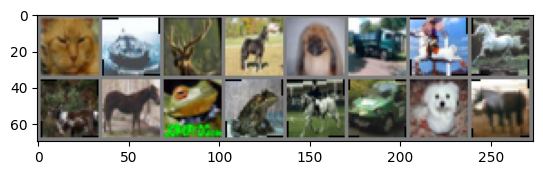

cat   ship  deer  horse dog   truck horse horse deer  horse frog  frog  horse car   dog   horse


In [9]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Model architecture

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
net = Classifier()
net

Classifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Experiemnts

1. 'SGD',
2. 'Adam',
3. 'RMSprop',
4. 'Adadelta',
5. 'Adagrad'

## Optimizers

In [12]:
class SGD:
    def __init__(self, model_params, lr=1e-3):
        self.model_params = list(model_params)
        self.lr = lr

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            param.sub_(self.lr * param.grad)

In [13]:
class SGDMomentum:
    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, v in zip(self.model_params, self.v):
            v.mul_(self.momentum).add_(param.grad)
            param.sub_(self.lr * v)

In [21]:
class Adagrad:
    def __init__(self, model_params, lr=1e-3, init_acc_sqr_grad=0, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.acc_sqr_grads = [torch.full_like(p, init_acc_sqr_grad) for p in self.model_params]
        self.eps = eps

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, acc_sqr_grad in zip(self.model_params, self.acc_sqr_grads):
            acc_sqr_grad.add_(param.grad * param.grad)
            std = acc_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [22]:
class Adadelta:
    def __init__(self, model_params, lr=1e-3, rho=0.9, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.rho = rho
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_deltas = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad, avg_sqr_delta in zip(self.model_params, \
                                                      self.avg_sqr_grads, \
                                                      self.avg_sqr_deltas):
            avg_sqr_grad.mul_(self.rho).add_(param.grad * param.grad * (1 - self.rho))
            std = avg_sqr_grad.add(self.eps).sqrt()
            delta = avg_sqr_delta.add(self.eps).sqrt().div(std).mul(param.grad)
            param.sub_(self.lr * delta)
            avg_sqr_delta.mul_(self.rho).add_(delta * delta * (1 - self.rho))

In [23]:
class RMSprop:
    def __init__(self, model_params, lr=1e-3, alpha=0.99, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad in zip(self.model_params, self.avg_sqr_grads):
            avg_sqr_grad.mul_(self.alpha).add_(param.grad * param.grad * (1 - self.alpha))
            std = avg_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [24]:
class RMSpropAlt:
    def __init__(self, model_params, lr=1e-3, alpha=0.99, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.avg_sqr_grads = [torch.ones_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad in zip(self.model_params, self.avg_sqr_grads):
            avg_sqr_grad.mul_(self.alpha).add_(param.grad * param.grad * (1 - self.alpha))
            std = avg_sqr_grad.add(self.eps).sqrt()
            param.sub_((self.lr / std) * param.grad)

In [25]:
class Adam:
    def __init__(self, model_params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.eps = eps
        self.avg_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.n_steps = 0

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_grad, avg_sqr_grad in zip(self.model_params, \
                                                 self.avg_grads, \
                                                 self.avg_sqr_grads):
            self.n_steps += 1
            avg_grad.mul_(self.beta_1).add_(param.grad * (1 - self.beta_1))
            avg_sqr_grad.mul_(self.beta_2).add_(param.grad * param.grad * (1 - self.beta_2))
            avg_grad_corrected = avg_grad.div(1 - self.beta_1 ** self.n_steps)
            avg_sqr_grad_corrected = avg_sqr_grad.div(1 - self.beta_2 ** self.n_steps)
            std = avg_sqr_grad_corrected.sqrt().add(self.eps)
            param.sub_(self.lr * avg_grad_corrected / std)

## Training and Validating
+ Record all losses and time from each epoch that the model trained.

In [26]:
class Trainer:
  def __init__(self, model, loss_fn, optimizer):
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.log = {
        'train_losses': [],
        'val_losses': [],
        'timer': []
    }

  def _train_per_epoch(self, epoch_index, training_dataloader):
    self.model.train()
    running_loss = 0.
    last_loss = 0.
    print(f'Training at epoch {epoch_index}')
    for i, data in tqdm(enumerate(training_dataloader)):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      self.optimizer.zero_grad()                # Compute the loss and its gradients
      outputs = self.model(inputs)
      loss = self.loss_fn(outputs, labels)
      loss.backward()                           # Compute the loss and its gradients
      self.optimizer.step()                     # Adjust learning weights

      running_loss += loss.item()
      if i % 1000 == 999:
        last_loss = running_loss / 1000.0
        # print(f'Batch {i+1} loss {last_loss}\n')
        self.log['train_losses'].append(last_loss)
        running_loss = 0.

    return last_loss

  def _eval_per_epoch(self, epoch_index, val_dataloader):
    self.model.eval()
    running_vloss = 0.
    # print(f'Validating at epoch {epoch_index}\n')
    with torch.no_grad():
      for i, data in tqdm(enumerate(val_dataloader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = self.model(inputs)
        loss = self.loss_fn(outputs, labels)
        running_vloss += loss

        self.log['val_losses'].append(running_vloss)
    avg_vloss = running_vloss / (i + 1)
    return  avg_vloss

  def fit(self, epochs, training_dataloader, val_dataloader):
    if val_dataloader == None:
      print('No validation during experiment')

    for epoch in range(epochs):
      avg_loss = self._train_per_epoch(epoch, training_dataloader)

      if val_dataloader:
        avg_vloss = self._eval_per_epoch(epoch, val_dataloader)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
  def save_results(self, dir):
    pickle_dump(dir, self.log)

In [20]:
net = Classifier().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = SGD(net.parameters(), lr=0.001)

trainer_sgd = Trainer(net, loss_fn, optimizer)
trainer_sgd.fit(epochs=50,
                training_dataloader=trainloader,
                val_dataloader=testloader)

3125it [00:36, 84.54it/s] 
625it [00:06, 94.75it/s] 


LOSS train 2.2970404481887816 valid 2.2943737506866455


3125it [00:36, 85.64it/s] 
625it [00:06, 92.46it/s] 


LOSS train 2.2582103266716005 valid 2.243999481201172


3125it [00:38, 80.89it/s]
625it [00:06, 91.66it/s] 


LOSS train 2.185080218911171 valid 2.169318437576294


3125it [00:38, 81.43it/s] 
625it [00:08, 70.05it/s]


LOSS train 2.1152351387739183 valid 2.0936756134033203


3125it [00:39, 78.80it/s]
625it [00:07, 82.64it/s] 


LOSS train 2.03965183198452 valid 2.023023843765259


3125it [00:40, 77.92it/s]
625it [00:07, 78.69it/s]


LOSS train 1.9861122357845307 valid 1.966172456741333


3125it [00:42, 73.55it/s]
625it [00:09, 67.65it/s] 


LOSS train 1.9348215351104736 valid 1.9144556522369385


3125it [00:45, 69.41it/s]
625it [00:08, 77.99it/s] 


LOSS train 1.8816676383018494 valid 1.8490134477615356


3125it [00:40, 77.10it/s]
625it [00:08, 70.97it/s] 


LOSS train 1.7961515266895294 valid 1.7641921043395996


3125it [00:41, 75.47it/s] 
625it [00:06, 92.69it/s] 


LOSS train 1.711112664937973 valid 1.6907528638839722


3125it [00:41, 75.55it/s]
625it [00:06, 92.32it/s] 


LOSS train 1.6723892822265625 valid 1.650328278541565


3125it [00:34, 89.60it/s] 
625it [00:06, 90.27it/s] 


LOSS train 1.6134210593700409 valid 1.6008844375610352


3125it [00:36, 85.20it/s] 
625it [00:06, 95.02it/s] 


LOSS train 1.5897566847801208 valid 1.568157434463501


3125it [00:40, 76.49it/s]
625it [00:08, 76.69it/s] 


LOSS train 1.5626567503213882 valid 1.538324236869812


3125it [00:46, 66.98it/s]
625it [00:08, 72.01it/s] 


LOSS train 1.5283327615261078 valid 1.5184824466705322


3125it [00:50, 61.71it/s]
625it [00:07, 78.56it/s] 


LOSS train 1.5032416266798974 valid 1.48983633518219


3125it [00:35, 87.72it/s] 
625it [00:06, 95.60it/s] 


LOSS train 1.473630697607994 valid 1.4809380769729614


3125it [00:40, 77.83it/s] 
625it [00:06, 93.94it/s] 


LOSS train 1.4642062762379646 valid 1.4477198123931885


3125it [00:40, 77.01it/s] 
625it [00:07, 88.17it/s] 


LOSS train 1.4200158346295357 valid 1.4360556602478027


3125it [00:37, 84.03it/s] 
625it [00:06, 95.83it/s] 


LOSS train 1.3962094098329545 valid 1.4153131246566772


3125it [00:34, 89.63it/s] 
625it [00:06, 92.38it/s] 


LOSS train 1.3802430730462074 valid 1.3949509859085083


3125it [00:35, 88.26it/s] 
625it [00:05, 106.35it/s]


LOSS train 1.3636320871710776 valid 1.3877311944961548


3125it [00:34, 90.28it/s] 
625it [00:06, 96.98it/s] 


LOSS train 1.3541983964443207 valid 1.3576968908309937


3125it [00:41, 75.50it/s] 
625it [00:07, 86.94it/s] 


LOSS train 1.3350003645420074 valid 1.3513224124908447


3125it [00:34, 91.16it/s] 
625it [00:06, 104.05it/s]


LOSS train 1.3175103302598 valid 1.3280999660491943


3125it [00:32, 97.05it/s] 
625it [00:05, 105.25it/s]


LOSS train 1.302621472299099 valid 1.3321667909622192


3125it [00:32, 95.50it/s] 
625it [00:05, 104.31it/s]


LOSS train 1.2875693575143814 valid 1.3086570501327515


3125it [00:31, 98.98it/s] 
625it [00:05, 104.50it/s]


LOSS train 1.2727516242265702 valid 1.3013495206832886


3125it [00:32, 96.99it/s] 
625it [00:05, 107.44it/s]


LOSS train 1.2584480033516885 valid 1.2863831520080566


3125it [00:35, 87.61it/s] 
625it [00:06, 91.44it/s] 


LOSS train 1.2481930856704713 valid 1.2660809755325317


3125it [00:34, 91.46it/s] 
625it [00:05, 104.94it/s]


LOSS train 1.2317883220911026 valid 1.2621309757232666


3125it [00:31, 97.75it/s] 
625it [00:06, 102.56it/s]


LOSS train 1.2166605902910232 valid 1.2638896703720093


3125it [00:31, 98.07it/s] 
625it [00:05, 104.48it/s]


LOSS train 1.2086516261100768 valid 1.2499793767929077


3125it [00:33, 93.13it/s] 
625it [00:06, 102.81it/s]


LOSS train 1.208329976260662 valid 1.2647970914840698


3125it [00:32, 96.24it/s] 
625it [00:06, 97.05it/s] 


LOSS train 1.1811936273872852 valid 1.2312222719192505


3125it [00:32, 96.12it/s] 
625it [00:06, 94.60it/s] 


LOSS train 1.1777133660912513 valid 1.2418174743652344


3125it [00:38, 81.11it/s] 
625it [00:05, 109.40it/s]


LOSS train 1.1818155100941659 valid 1.2330653667449951


3125it [00:31, 97.99it/s] 
625it [00:05, 105.01it/s]


LOSS train 1.1534330661594867 valid 1.208096981048584


3125it [00:31, 99.07it/s] 
625it [00:05, 105.68it/s]


LOSS train 1.154020947366953 valid 1.1911438703536987


3125it [00:32, 97.03it/s] 
625it [00:06, 100.76it/s]


LOSS train 1.1222229376733304 valid 1.19154953956604


3125it [00:32, 94.97it/s] 
625it [00:06, 101.71it/s]


LOSS train 1.1313110392987729 valid 1.210516333580017


3125it [00:32, 94.76it/s] 
625it [00:07, 83.73it/s] 


LOSS train 1.12369044020772 valid 1.176518440246582


3125it [00:32, 97.08it/s] 
625it [00:05, 104.80it/s]


LOSS train 1.1178275382518768 valid 1.1692999601364136


3125it [00:32, 94.71it/s] 
625it [00:06, 102.16it/s]


LOSS train 1.08750602170825 valid 1.1556748151779175


3125it [00:33, 93.69it/s] 
625it [00:05, 104.76it/s]


LOSS train 1.0870252019166946 valid 1.1596193313598633


3125it [00:32, 97.18it/s] 
625it [00:06, 102.41it/s]


LOSS train 1.090961868852377 valid 1.1393028497695923


3125it [00:32, 96.67it/s] 
625it [00:06, 101.76it/s]


LOSS train 1.061150484651327 valid 1.1441901922225952


3125it [00:32, 95.71it/s] 
625it [00:06, 99.67it/s] 


LOSS train 1.0687541628181934 valid 1.1401556730270386


3125it [00:35, 89.10it/s] 
625it [00:06, 99.90it/s] 


LOSS train 1.0757492104172706 valid 1.132637858390808


3125it [00:34, 90.43it/s] 
625it [00:05, 104.31it/s]

LOSS train 1.0502911889851094 valid 1.1261248588562012


In [31]:
net = Classifier().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = SGDMomentum(net.parameters())

trainer_sgdmm = Trainer(net, loss_fn, optimizer)
trainer_sgdmm.fit(epochs=50,
                training_dataloader=trainloader,
                val_dataloader=testloader)
trainer_sgdmm.save_results(dir='./log/history_sgdmm.pkl')

Training at epoch 0


3125it [00:31, 98.52it/s] 
625it [00:05, 109.38it/s]


LOSS train 1.893019605755806 valid 1.780671238899231
Training at epoch 1


3125it [00:30, 103.15it/s]
625it [00:05, 111.27it/s]


LOSS train 1.5780270292758942 valid 1.5130624771118164
Training at epoch 2


3125it [00:31, 99.81it/s] 
625it [00:05, 110.13it/s]


LOSS train 1.44824200206995 valid 1.390496850013733
Training at epoch 3


3125it [00:31, 98.72it/s] 
625it [00:05, 107.28it/s]


LOSS train 1.3386484495401383 valid 1.307425618171692
Training at epoch 4


3125it [00:31, 98.94it/s] 
625it [00:06, 103.15it/s]


LOSS train 1.25952041721344 valid 1.2426235675811768
Training at epoch 5


3125it [00:31, 100.23it/s]
625it [00:05, 108.47it/s]


LOSS train 1.1841777455508709 valid 1.19752037525177
Training at epoch 6


3125it [00:31, 98.79it/s] 
625it [00:05, 104.32it/s]


LOSS train 1.149178743213415 valid 1.1897393465042114
Training at epoch 7


3125it [00:32, 95.26it/s] 
625it [00:06, 102.31it/s]


LOSS train 1.0942663187384605 valid 1.1682785749435425
Training at epoch 8


3125it [00:33, 94.51it/s] 
625it [00:06, 103.02it/s]


LOSS train 1.0567123391032218 valid 1.1575671434402466
Training at epoch 9


3125it [00:33, 94.59it/s] 
625it [00:05, 104.60it/s]


LOSS train 1.0214172794818879 valid 1.1670249700546265
Training at epoch 10


3125it [00:32, 95.00it/s] 
625it [00:06, 103.80it/s]


LOSS train 0.9838847577273846 valid 1.0919584035873413
Training at epoch 11


3125it [00:32, 95.55it/s] 
625it [00:05, 106.49it/s]


LOSS train 0.967892194122076 valid 1.0872516632080078
Training at epoch 12


3125it [00:31, 97.66it/s] 
625it [00:05, 104.25it/s]


LOSS train 0.9530248693823814 valid 1.1307930946350098
Training at epoch 13


3125it [00:32, 96.25it/s] 
625it [00:06, 101.94it/s]


LOSS train 0.9232687461674214 valid 1.0736885070800781
Training at epoch 14


3125it [00:32, 95.92it/s] 
625it [00:05, 106.31it/s]


LOSS train 0.8916550527513027 valid 1.1017783880233765
Training at epoch 15


3125it [00:33, 92.27it/s] 
625it [00:08, 75.54it/s] 


LOSS train 0.8781555902957916 valid 1.0832791328430176
Training at epoch 16


3125it [00:42, 73.09it/s] 
625it [00:13, 48.02it/s]


LOSS train 0.8565870213061572 valid 1.055981159210205
Training at epoch 17


3125it [00:42, 72.70it/s] 
625it [00:05, 117.59it/s]


LOSS train 0.8431380521059036 valid 1.080020785331726
Training at epoch 18


3125it [00:29, 107.10it/s]
625it [00:05, 112.05it/s]


LOSS train 0.8078141071498394 valid 1.1079607009887695
Training at epoch 19


3125it [00:30, 103.54it/s]
625it [00:06, 96.48it/s] 


LOSS train 0.7990357018113137 valid 1.1118494272232056
Training at epoch 20


3125it [00:30, 102.05it/s]
625it [00:05, 112.35it/s]


LOSS train 0.7870064327716827 valid 1.1027432680130005
Training at epoch 21


3125it [00:28, 109.04it/s]
625it [00:05, 118.08it/s]


LOSS train 0.7644926235824824 valid 1.1503146886825562
Training at epoch 22


3125it [00:30, 102.23it/s]
625it [00:05, 110.31it/s]


LOSS train 0.7543505990430712 valid 1.1004810333251953
Training at epoch 23


3125it [00:28, 108.35it/s]
625it [00:05, 112.17it/s]


LOSS train 0.7228976230323315 valid 1.1304982900619507
Training at epoch 24


3125it [00:29, 104.56it/s]
625it [00:05, 113.33it/s]


LOSS train 0.718145600527525 valid 1.1204638481140137
Training at epoch 25


3125it [00:29, 104.46it/s]
625it [00:05, 110.34it/s]


LOSS train 0.7268483562320471 valid 1.1188857555389404
Training at epoch 26


3125it [00:28, 108.41it/s]
625it [00:05, 119.30it/s]


LOSS train 0.7004478200376034 valid 1.173764944076538
Training at epoch 27


3125it [00:30, 102.12it/s]
625it [00:05, 114.57it/s]


LOSS train 0.6807235322892666 valid 1.1800094842910767
Training at epoch 28


3125it [00:28, 110.55it/s]
625it [00:05, 116.26it/s]


LOSS train 0.6862462809383869 valid 1.1843081712722778
Training at epoch 29


3125it [00:29, 106.36it/s]
625it [00:05, 113.57it/s]


LOSS train 0.6551439059078693 valid 1.162374496459961
Training at epoch 30


3125it [00:28, 108.02it/s]
625it [00:05, 115.87it/s]


LOSS train 0.6547146906480193 valid 1.1932203769683838
Training at epoch 31


3125it [00:27, 111.72it/s]
625it [00:05, 118.03it/s]


LOSS train 0.6412237274087965 valid 1.1855076551437378
Training at epoch 32


3125it [00:28, 107.81it/s]
625it [00:05, 113.97it/s]


LOSS train 0.6339324788302183 valid 1.2161109447479248
Training at epoch 33


3125it [00:30, 103.91it/s]
625it [00:05, 114.20it/s]


LOSS train 0.6236771057322621 valid 1.2399715185165405
Training at epoch 34


3125it [00:28, 108.26it/s]
625it [00:05, 118.68it/s]


LOSS train 0.60840164437145 valid 1.2405651807785034
Training at epoch 35


3125it [00:30, 103.18it/s]
625it [00:05, 113.31it/s]


LOSS train 0.5985239822492003 valid 1.2577283382415771
Training at epoch 36


3125it [00:28, 108.70it/s]
625it [00:05, 117.42it/s]


LOSS train 0.5952840552777052 valid 1.2988970279693604
Training at epoch 37


3125it [00:29, 106.22it/s]
625it [00:05, 112.86it/s]


LOSS train 0.5921451961174607 valid 1.297815203666687
Training at epoch 38


3125it [00:30, 103.80it/s]
625it [00:05, 118.71it/s]


LOSS train 0.5805223995223642 valid 1.3629226684570312
Training at epoch 39


3125it [00:30, 101.98it/s]
625it [00:05, 112.12it/s]


LOSS train 0.5842991223186255 valid 1.2976237535476685
Training at epoch 40


3125it [00:30, 103.49it/s]
625it [00:05, 106.49it/s]


LOSS train 0.5641172861307859 valid 1.3242334127426147
Training at epoch 41


3125it [00:30, 102.52it/s]
625it [00:05, 113.18it/s]


LOSS train 0.5579120109677315 valid 1.3431276082992554
Training at epoch 42


3125it [00:30, 101.50it/s]
625it [00:05, 111.03it/s]


LOSS train 0.5543890095725655 valid 1.391547679901123
Training at epoch 43


3125it [00:30, 101.97it/s]
625it [00:05, 110.93it/s]


LOSS train 0.5523211850523949 valid 1.399604320526123
Training at epoch 44


3125it [00:30, 102.38it/s]
625it [00:05, 112.11it/s]


LOSS train 0.5380038618706167 valid 1.383516550064087
Training at epoch 45


3125it [00:30, 102.37it/s]
625it [00:05, 110.82it/s]


LOSS train 0.5254363614022732 valid 1.416682243347168
Training at epoch 46


3125it [00:28, 108.45it/s]
625it [00:05, 117.87it/s]


LOSS train 0.5274605380669236 valid 1.4413777589797974
Training at epoch 47


3125it [00:29, 104.90it/s]
625it [00:05, 110.44it/s]


LOSS train 0.5277469575107098 valid 1.4013952016830444
Training at epoch 48


3125it [00:30, 102.72it/s]
625it [00:05, 112.53it/s]


LOSS train 0.5196764159500599 valid 1.498774528503418
Training at epoch 49


3125it [00:30, 101.95it/s]
625it [00:05, 113.57it/s]

LOSS train 0.513503965754062 valid 1.4940112829208374


In [32]:
net = Classifier().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = Adagrad(net.parameters())

trainer_adg = Trainer(net, loss_fn, optimizer)
trainer_adg.fit(epochs=50,
                training_dataloader=trainloader,
                val_dataloader=testloader)
trainer_adg.save_results(dir='./log/history_adg.pkl')

Training at epoch 0


3125it [00:33, 94.57it/s] 
625it [00:05, 109.71it/s]


LOSS train 1.8459426724910737 valid 1.8125988245010376
Training at epoch 1


3125it [00:33, 94.19it/s] 
625it [00:05, 111.28it/s]


LOSS train 1.7751143996715546 valid 1.7556970119476318
Training at epoch 2


3125it [00:33, 94.23it/s] 
625it [00:05, 111.49it/s]


LOSS train 1.7186226094961166 valid 1.718002438545227
Training at epoch 3


3125it [00:33, 94.58it/s] 
625it [00:05, 114.28it/s]


LOSS train 1.7025088893175124 valid 1.6919019222259521
Training at epoch 4


3125it [00:34, 89.61it/s] 
625it [00:06, 99.06it/s] 


LOSS train 1.6781008942127227 valid 1.671380639076233
Training at epoch 5


3125it [00:34, 91.67it/s] 
625it [00:06, 103.60it/s]


LOSS train 1.6621187241077424 valid 1.6507892608642578
Training at epoch 6


3125it [00:35, 88.93it/s] 
625it [00:06, 102.01it/s]


LOSS train 1.654509662270546 valid 1.639040231704712
Training at epoch 7


3125it [00:34, 90.86it/s] 
625it [00:07, 88.43it/s] 


LOSS train 1.643330036878586 valid 1.6233153343200684
Training at epoch 8


3125it [00:37, 82.72it/s]
625it [00:06, 103.20it/s]


LOSS train 1.6210207448601723 valid 1.6128140687942505
Training at epoch 9


3125it [00:36, 86.31it/s]
625it [00:06, 103.07it/s]


LOSS train 1.6110586899518966 valid 1.6036149263381958
Training at epoch 10


3125it [00:35, 86.89it/s]
625it [00:06, 101.74it/s]


LOSS train 1.606819253385067 valid 1.5921226739883423
Training at epoch 11


3125it [00:42, 72.74it/s]
625it [00:07, 89.04it/s] 


LOSS train 1.5794685580730439 valid 1.584563970565796
Training at epoch 12


3125it [00:46, 66.86it/s]
625it [00:06, 95.84it/s] 


LOSS train 1.589145793378353 valid 1.5773873329162598
Training at epoch 13


3125it [00:37, 83.90it/s] 
625it [00:06, 103.82it/s]


LOSS train 1.580911274433136 valid 1.5713375806808472
Training at epoch 14


3125it [00:37, 84.32it/s]
625it [00:06, 93.12it/s] 


LOSS train 1.573999654531479 valid 1.5620050430297852
Training at epoch 15


3125it [00:35, 86.84it/s] 
625it [00:05, 104.61it/s]


LOSS train 1.5687531331777573 valid 1.5577659606933594
Training at epoch 16


3125it [00:35, 88.52it/s] 
625it [00:05, 104.50it/s]


LOSS train 1.5575849905014039 valid 1.5521321296691895
Training at epoch 17


3125it [00:35, 87.81it/s] 
625it [00:06, 103.24it/s]


LOSS train 1.5579469571709632 valid 1.546875
Training at epoch 18


3125it [00:35, 88.61it/s] 
625it [00:05, 106.27it/s]


LOSS train 1.5392245010733605 valid 1.5432912111282349
Training at epoch 19


3125it [00:36, 86.74it/s] 
625it [00:05, 106.16it/s]


LOSS train 1.5301370199918747 valid 1.5359793901443481
Training at epoch 20


3125it [00:35, 88.40it/s] 
625it [00:06, 102.73it/s]


LOSS train 1.5321691117882728 valid 1.533200979232788
Training at epoch 21


3125it [00:35, 88.36it/s] 
625it [00:05, 106.76it/s]


LOSS train 1.5342396075725555 valid 1.5282795429229736
Training at epoch 22


3125it [00:35, 88.41it/s]
625it [00:06, 103.46it/s]


LOSS train 1.5211012235879897 valid 1.524307370185852
Training at epoch 23


3125it [00:36, 86.79it/s]
625it [00:06, 103.82it/s]


LOSS train 1.5202054577469826 valid 1.5219154357910156
Training at epoch 24


3125it [00:35, 88.12it/s] 
625it [00:06, 101.73it/s]


LOSS train 1.5210567165017128 valid 1.5181248188018799
Training at epoch 25


3125it [00:35, 87.37it/s]
625it [00:06, 101.97it/s]


LOSS train 1.5084627492427827 valid 1.5152368545532227
Training at epoch 26


3125it [00:35, 87.43it/s]
625it [00:06, 102.49it/s]


LOSS train 1.512847716331482 valid 1.5110751390457153
Training at epoch 27


3125it [00:35, 88.37it/s] 
625it [00:06, 97.18it/s] 


LOSS train 1.504571824848652 valid 1.5079741477966309
Training at epoch 28


3125it [00:36, 85.93it/s]
625it [00:06, 101.03it/s]


LOSS train 1.5083529888391494 valid 1.5054243803024292
Training at epoch 29


3125it [00:36, 86.43it/s]
625it [00:06, 98.27it/s] 


LOSS train 1.5090165123343469 valid 1.5016950368881226
Training at epoch 30


3125it [00:36, 86.78it/s]
625it [00:06, 102.19it/s]


LOSS train 1.4939188385605813 valid 1.5005862712860107
Training at epoch 31


3125it [00:36, 85.39it/s]
625it [00:06, 98.47it/s] 


LOSS train 1.4992181879878044 valid 1.4976394176483154
Training at epoch 32


3125it [00:37, 82.69it/s]
625it [00:06, 98.96it/s] 


LOSS train 1.5019043927192688 valid 1.4954882860183716
Training at epoch 33


3125it [00:36, 84.48it/s] 
625it [00:06, 94.38it/s] 


LOSS train 1.4886629826426505 valid 1.4912775754928589
Training at epoch 34


3125it [00:36, 85.14it/s]
625it [00:06, 101.10it/s]


LOSS train 1.483580026805401 valid 1.4906044006347656
Training at epoch 35


3125it [00:37, 84.08it/s]
625it [00:06, 102.73it/s]


LOSS train 1.4782536751627922 valid 1.4879428148269653
Training at epoch 36


3125it [00:37, 82.57it/s]
625it [00:06, 99.36it/s] 


LOSS train 1.4855703521966934 valid 1.486496090888977
Training at epoch 37


3125it [00:36, 85.07it/s]
625it [00:06, 101.79it/s]


LOSS train 1.4742490462064743 valid 1.4842849969863892
Training at epoch 38


3125it [00:37, 83.63it/s]
625it [00:06, 97.56it/s] 


LOSS train 1.481759905576706 valid 1.4812854528427124
Training at epoch 39


3125it [00:36, 85.50it/s]
625it [00:06, 103.49it/s]


LOSS train 1.4866465567946434 valid 1.478794813156128
Training at epoch 40


3125it [00:52, 59.90it/s]
625it [00:10, 61.08it/s]


LOSS train 1.4781852397918702 valid 1.477598786354065
Training at epoch 41


3125it [00:49, 62.55it/s]
625it [00:08, 71.04it/s]


LOSS train 1.4718808121085167 valid 1.4752315282821655
Training at epoch 42


3125it [00:41, 76.21it/s]
625it [00:06, 97.67it/s] 


LOSS train 1.4677396498918533 valid 1.4727076292037964
Training at epoch 43


3125it [00:46, 66.54it/s]
625it [00:07, 83.58it/s] 


LOSS train 1.4636027158498763 valid 1.4724030494689941
Training at epoch 44


3125it [00:41, 74.66it/s]
625it [00:07, 85.60it/s] 


LOSS train 1.4649805496335029 valid 1.4691859483718872
Training at epoch 45


3125it [00:41, 74.66it/s]
625it [00:06, 89.52it/s] 


LOSS train 1.4678713277578355 valid 1.4685157537460327
Training at epoch 46


3125it [00:42, 74.37it/s]
625it [00:07, 86.73it/s] 


LOSS train 1.453267517566681 valid 1.4660210609436035
Training at epoch 47


3125it [00:40, 77.88it/s] 
625it [00:05, 104.36it/s]


LOSS train 1.4570557844638825 valid 1.4636489152908325
Training at epoch 48


3125it [00:35, 88.17it/s] 
625it [00:07, 88.27it/s] 


LOSS train 1.4617499156594276 valid 1.4631329774856567
Training at epoch 49


3125it [00:41, 75.22it/s]
625it [00:09, 65.28it/s]

LOSS train 1.4489388831853867 valid 1.4626383781433105


In [33]:
net = Classifier().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = Adadelta(net.parameters())

trainer_adel = Trainer(net, loss_fn, optimizer)
trainer_adel.fit(epochs=50,
                training_dataloader=trainloader,
                val_dataloader=testloader)
trainer_adel.save_results(dir='./log/history_adel.pkl')

Training at epoch 0


3125it [00:53, 58.17it/s]
625it [00:06, 99.55it/s] 


LOSS train 2.3050137743949892 valid 2.304311990737915
Training at epoch 1


3125it [00:46, 67.42it/s]
625it [00:06, 98.19it/s] 


LOSS train 2.3031319415569307 valid 2.3033366203308105
Training at epoch 2


3125it [00:44, 69.71it/s]
625it [00:06, 99.42it/s] 


LOSS train 2.3027157521247865 valid 2.3022546768188477
Training at epoch 3


3125it [00:42, 73.54it/s]
625it [00:06, 97.66it/s] 


LOSS train 2.3020190765857698 valid 2.3010380268096924
Training at epoch 4


3125it [00:44, 70.11it/s]
625it [00:06, 98.28it/s] 


LOSS train 2.300064086675644 valid 2.299809217453003
Training at epoch 5


3125it [00:45, 69.00it/s]
625it [00:06, 98.99it/s] 


LOSS train 2.299491996526718 valid 2.298480272293091
Training at epoch 6


3125it [00:44, 70.66it/s]
625it [00:06, 96.92it/s] 


LOSS train 2.2976461186408996 valid 2.297031879425049
Training at epoch 7


3125it [00:43, 72.03it/s]
625it [00:06, 100.96it/s]


LOSS train 2.2957500789165497 valid 2.2954211235046387
Training at epoch 8


3125it [00:46, 67.58it/s]
625it [00:06, 102.43it/s]


LOSS train 2.2943213918209078 valid 2.2936511039733887
Training at epoch 9


3125it [00:44, 70.25it/s]
625it [00:06, 102.22it/s]


LOSS train 2.2929069595336915 valid 2.2916464805603027
Training at epoch 10


3125it [00:44, 70.72it/s]
625it [00:07, 88.38it/s] 


LOSS train 2.2891562776565553 valid 2.28941011428833
Training at epoch 11


3125it [00:49, 63.63it/s]
625it [00:06, 98.70it/s] 


LOSS train 2.2877969844341277 valid 2.286985397338867
Training at epoch 12


3125it [00:44, 70.09it/s]
625it [00:06, 95.24it/s] 


LOSS train 2.2856110775470735 valid 2.2842371463775635
Training at epoch 13


3125it [00:56, 54.90it/s]
625it [00:07, 85.74it/s] 


LOSS train 2.282465306520462 valid 2.2812070846557617
Training at epoch 14


3125it [00:41, 75.51it/s]
625it [00:06, 103.22it/s]


LOSS train 2.2777419130802157 valid 2.277923345565796
Training at epoch 15


3125it [00:41, 74.50it/s]
625it [00:06, 96.03it/s] 


LOSS train 2.2762498693466187 valid 2.274279832839966
Training at epoch 16


3125it [00:42, 73.06it/s]
625it [00:06, 99.29it/s] 


LOSS train 2.2708570890426634 valid 2.2702999114990234
Training at epoch 17


3125it [00:42, 73.44it/s]
625it [00:06, 91.72it/s] 


LOSS train 2.2676704392433167 valid 2.2659859657287598
Training at epoch 18


3125it [00:44, 69.51it/s]
625it [00:05, 109.87it/s]


LOSS train 2.2629901514053343 valid 2.2613654136657715
Training at epoch 19


3125it [00:40, 77.93it/s]
625it [00:05, 117.38it/s]


LOSS train 2.2575026364326476 valid 2.256394863128662
Training at epoch 20


3125it [00:38, 81.70it/s]
625it [00:05, 115.73it/s]


LOSS train 2.2531862466335295 valid 2.251049280166626
Training at epoch 21


3125it [00:39, 79.45it/s]
625it [00:05, 114.02it/s]


LOSS train 2.2473598535060884 valid 2.2453064918518066
Training at epoch 22


3125it [00:37, 82.78it/s]
625it [00:05, 118.90it/s]


LOSS train 2.2401262958049775 valid 2.239051580429077
Training at epoch 23


3125it [00:38, 80.69it/s]
625it [00:05, 112.56it/s]


LOSS train 2.236306165933609 valid 2.2325541973114014
Training at epoch 24


3125it [00:39, 79.77it/s]
625it [00:05, 118.79it/s]


LOSS train 2.2298932671546936 valid 2.2257909774780273
Training at epoch 25


3125it [00:37, 83.60it/s]
625it [00:05, 106.77it/s]


LOSS train 2.2220126016139985 valid 2.218881368637085
Training at epoch 26


3125it [00:44, 69.94it/s]
625it [00:06, 99.52it/s] 


LOSS train 2.214440248966217 valid 2.2117254734039307
Training at epoch 27


3125it [00:48, 64.75it/s]
625it [00:07, 85.43it/s] 


LOSS train 2.2081474130153658 valid 2.2044851779937744
Training at epoch 28


3125it [00:47, 65.18it/s]
625it [00:07, 81.41it/s] 


LOSS train 2.198707007884979 valid 2.197242259979248
Training at epoch 29


3125it [00:49, 63.16it/s]
625it [00:07, 82.65it/s] 


LOSS train 2.193224925994873 valid 2.1898550987243652
Training at epoch 30


3125it [00:52, 60.03it/s]
625it [00:08, 70.75it/s] 


LOSS train 2.186587030172348 valid 2.182476758956909
Training at epoch 31


3125it [00:49, 63.62it/s]
625it [00:06, 94.50it/s] 


LOSS train 2.1793591579198837 valid 2.174978733062744
Training at epoch 32


3125it [00:56, 55.33it/s]
625it [00:07, 83.34it/s] 


LOSS train 2.1698749274015428 valid 2.1678755283355713
Training at epoch 33


3125it [00:49, 62.90it/s]
625it [00:07, 81.01it/s] 


LOSS train 2.1612491736412047 valid 2.1606459617614746
Training at epoch 34


3125it [00:44, 70.13it/s]
625it [00:06, 97.39it/s] 


LOSS train 2.156211445569992 valid 2.1534647941589355
Training at epoch 35


3125it [00:48, 64.80it/s]
625it [00:07, 78.64it/s] 


LOSS train 2.148947208404541 valid 2.1466712951660156
Training at epoch 36


3125it [00:47, 66.28it/s]
625it [00:06, 101.40it/s]


LOSS train 2.146310706138611 valid 2.1402945518493652
Training at epoch 37


3125it [00:43, 72.53it/s]
625it [00:05, 109.72it/s]


LOSS train 2.137475578069687 valid 2.1339385509490967
Training at epoch 38


3125it [00:40, 76.55it/s]
625it [00:05, 108.22it/s]


LOSS train 2.131325417280197 valid 2.1277284622192383
Training at epoch 39


3125it [00:44, 69.80it/s]
625it [00:07, 86.53it/s] 


LOSS train 2.1271482026576995 valid 2.1217901706695557
Training at epoch 40


3125it [00:41, 74.64it/s]
625it [00:06, 102.60it/s]


LOSS train 2.118579910993576 valid 2.116133451461792
Training at epoch 41


3125it [00:40, 77.07it/s]
625it [00:06, 102.81it/s]


LOSS train 2.1159939119815827 valid 2.110715866088867
Training at epoch 42


3125it [00:44, 70.31it/s]
625it [00:06, 95.33it/s] 


LOSS train 2.1114834752082823 valid 2.1053285598754883
Training at epoch 43


3125it [00:41, 74.62it/s]
625it [00:07, 83.01it/s] 


LOSS train 2.105056190252304 valid 2.1003165245056152
Training at epoch 44


3125it [00:42, 73.53it/s]
625it [00:06, 104.06it/s]


LOSS train 2.0975033168792723 valid 2.095449447631836
Training at epoch 45


3125it [00:43, 72.26it/s]
625it [00:06, 103.58it/s]


LOSS train 2.094288584947586 valid 2.0907530784606934
Training at epoch 46


3125it [00:43, 71.55it/s]
625it [00:06, 93.95it/s] 


LOSS train 2.09325487780571 valid 2.086209297180176
Training at epoch 47


3125it [00:45, 68.58it/s]
625it [00:06, 92.59it/s] 


LOSS train 2.0853074786663055 valid 2.081627368927002
Training at epoch 48


3125it [00:44, 69.73it/s]
625it [00:07, 82.35it/s] 


LOSS train 2.0816793624162675 valid 2.077559471130371
Training at epoch 49


3125it [00:42, 72.79it/s]
625it [00:06, 101.47it/s]

LOSS train 2.0749768804311755 valid 2.073387861251831


In [34]:
net = Classifier().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = RMSprop(net.parameters())

trainer_rmsp = Trainer(net, loss_fn, optimizer)
trainer_rmsp.fit(epochs=50,
                training_dataloader=trainloader,
                val_dataloader=testloader)
trainer_rmsp.save_results(dir='./log/history_rmsp.pkl')

Training at epoch 0


3125it [00:52, 59.72it/s]
625it [00:11, 52.17it/s] 


LOSS train 1.4309768927693367 valid 1.3687487840652466
Training at epoch 1


3125it [00:43, 71.89it/s]
625it [00:06, 99.92it/s] 


LOSS train 1.281999400615692 valid 1.2660831212997437
Training at epoch 2


3125it [00:37, 82.66it/s]
625it [00:06, 102.37it/s]


LOSS train 1.1857946714758874 valid 1.1990734338760376
Training at epoch 3


3125it [00:37, 84.24it/s]
625it [00:05, 104.27it/s]


LOSS train 1.1158673601448537 valid 1.1899940967559814
Training at epoch 4


3125it [00:35, 87.19it/s]
625it [00:05, 106.06it/s]


LOSS train 1.0765038818717003 valid 1.1662291288375854
Training at epoch 5


3125it [00:38, 80.27it/s]
625it [00:05, 109.32it/s]


LOSS train 1.0574401303231715 valid 1.1507840156555176
Training at epoch 6


3125it [00:34, 89.56it/s] 
625it [00:05, 105.08it/s]


LOSS train 0.999069620847702 valid 1.131582498550415
Training at epoch 7


3125it [00:36, 85.76it/s] 
625it [00:06, 100.12it/s]


LOSS train 0.9783842507004737 valid 1.1678608655929565
Training at epoch 8


3125it [00:38, 81.50it/s]
625it [00:06, 101.06it/s]


LOSS train 0.9641360742598772 valid 1.1538276672363281
Training at epoch 9


3125it [00:37, 82.38it/s]
625it [00:06, 99.80it/s] 


LOSS train 0.9228573652952909 valid 1.161759376525879
Training at epoch 10


3125it [00:38, 81.56it/s]
625it [00:06, 97.29it/s] 


LOSS train 0.9032499629557132 valid 1.131704568862915
Training at epoch 11


3125it [00:37, 82.80it/s]
625it [00:07, 88.19it/s] 


LOSS train 0.878725957378745 valid 1.161225438117981
Training at epoch 12


3125it [00:38, 80.45it/s]
625it [00:06, 95.76it/s] 


LOSS train 0.8586737968027591 valid 1.1873233318328857
Training at epoch 13


3125it [00:38, 81.59it/s]
625it [00:06, 100.04it/s]


LOSS train 0.8505779951959849 valid 1.1840165853500366
Training at epoch 14


3125it [00:38, 80.59it/s]
625it [00:06, 98.13it/s] 


LOSS train 0.8459179162085056 valid 1.1930731534957886
Training at epoch 15


3125it [00:38, 81.61it/s]
625it [00:06, 95.93it/s] 


LOSS train 0.8186509591341019 valid 1.20229971408844
Training at epoch 16


3125it [00:38, 80.51it/s]
625it [00:06, 94.96it/s] 


LOSS train 0.8013502186983824 valid 1.2507117986679077
Training at epoch 17


3125it [00:38, 81.91it/s]
625it [00:06, 94.20it/s] 


LOSS train 0.8006497910767794 valid 1.2522199153900146
Training at epoch 18


3125it [00:40, 77.50it/s]
625it [00:06, 98.51it/s] 


LOSS train 0.7932629477530718 valid 1.2121988534927368
Training at epoch 19


3125it [00:46, 67.64it/s]
625it [00:06, 102.13it/s]


LOSS train 0.7689580910801888 valid 1.2787928581237793
Training at epoch 20


3125it [00:37, 82.45it/s]
625it [00:06, 98.54it/s] 


LOSS train 0.7739016738124191 valid 1.328004240989685
Training at epoch 21


3125it [00:41, 75.92it/s]
625it [00:06, 89.92it/s] 


LOSS train 0.7629473299086094 valid 1.3114607334136963
Training at epoch 22


3125it [00:40, 77.25it/s]
625it [00:06, 98.44it/s] 


LOSS train 0.7607651832550764 valid 1.3877273797988892
Training at epoch 23


3125it [00:39, 78.31it/s]
625it [00:06, 98.55it/s] 


LOSS train 0.7391936460882426 valid 1.332993984222412
Training at epoch 24


3125it [00:37, 82.26it/s]
625it [00:06, 99.08it/s] 


LOSS train 0.7398540972098708 valid 1.3954459428787231
Training at epoch 25


3125it [00:38, 81.26it/s]
625it [00:06, 97.58it/s] 


LOSS train 0.7304510319903493 valid 1.311008095741272
Training at epoch 26


3125it [00:38, 80.54it/s]
625it [00:06, 97.30it/s] 


LOSS train 0.7376810392513872 valid 1.3801857233047485
Training at epoch 27


3125it [00:39, 78.93it/s]
625it [00:06, 98.62it/s] 


LOSS train 0.7321732337996364 valid 1.3856161832809448
Training at epoch 28


3125it [00:38, 81.37it/s]
625it [00:06, 100.71it/s]


LOSS train 0.7332556488737464 valid 1.4180854558944702
Training at epoch 29


3125it [00:38, 80.15it/s]
625it [00:06, 98.82it/s] 


LOSS train 0.7279430418424309 valid 1.3954854011535645
Training at epoch 30


3125it [00:38, 81.88it/s]
625it [00:06, 100.14it/s]


LOSS train 0.726781549230218 valid 1.3641380071640015
Training at epoch 31


3125it [00:38, 81.76it/s]
625it [00:06, 101.31it/s]


LOSS train 0.7187142038717866 valid 1.5037388801574707
Training at epoch 32


3125it [00:38, 81.16it/s]
625it [00:06, 92.48it/s] 


LOSS train 0.7096991331055761 valid 1.3793537616729736
Training at epoch 33


3125it [00:42, 73.54it/s]
625it [00:08, 74.41it/s] 


LOSS train 0.7084870520532132 valid 1.4070165157318115
Training at epoch 34


3125it [00:44, 69.89it/s]
625it [00:08, 72.55it/s] 


LOSS train 0.7093354904986918 valid 1.4403743743896484
Training at epoch 35


3125it [00:41, 75.73it/s]
625it [00:07, 80.42it/s] 


LOSS train 0.7050630066841841 valid 1.5047775506973267
Training at epoch 36


3125it [00:51, 60.44it/s]
625it [00:07, 87.50it/s] 


LOSS train 0.6899773151576519 valid 1.42522394657135
Training at epoch 37


3125it [00:42, 73.29it/s]
625it [00:07, 84.22it/s] 


LOSS train 0.6952668239474297 valid 1.4258519411087036
Training at epoch 38


3125it [00:42, 73.15it/s]
625it [00:07, 87.30it/s] 


LOSS train 0.6885289953649044 valid 1.526963233947754
Training at epoch 39


3125it [00:42, 73.24it/s]
625it [00:07, 84.62it/s] 


LOSS train 0.6972002603560686 valid 1.54683256149292
Training at epoch 40


3125it [00:41, 75.18it/s]
625it [00:06, 93.71it/s] 


LOSS train 0.6924982520714402 valid 1.4906271696090698
Training at epoch 41


3125it [00:41, 74.48it/s]
625it [00:06, 92.25it/s] 


LOSS train 0.6904849290251732 valid 1.4403042793273926
Training at epoch 42


3125it [00:44, 70.37it/s]
625it [00:11, 52.66it/s] 


LOSS train 0.6992010229751467 valid 1.5240117311477661
Training at epoch 43


3125it [00:49, 63.23it/s] 
625it [00:12, 48.37it/s] 


LOSS train 0.6900052329376339 valid 1.4957412481307983
Training at epoch 44


3125it [00:36, 84.86it/s] 
625it [00:06, 94.84it/s] 


LOSS train 0.6948720648139716 valid 1.553746223449707
Training at epoch 45


3125it [00:43, 71.56it/s]
625it [00:06, 97.67it/s] 


LOSS train 0.6810532169491053 valid 1.6961270570755005
Training at epoch 46


3125it [00:40, 77.29it/s]
625it [00:06, 96.68it/s] 


LOSS train 0.6860813117995859 valid 1.6072911024093628
Training at epoch 47


3125it [00:41, 74.61it/s]
625it [00:07, 88.08it/s] 


LOSS train 0.669821159195155 valid 1.594376802444458
Training at epoch 48


3125it [00:42, 73.76it/s]
625it [00:07, 82.99it/s] 


LOSS train 0.6800922923237085 valid 1.531369924545288
Training at epoch 49


3125it [00:43, 71.71it/s]
625it [00:08, 72.09it/s] 

LOSS train 0.6888386958353221 valid 1.5486325025558472


In [35]:
net = Classifier().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = RMSpropAlt(net.parameters())

trainer_rmspa = Trainer(net, loss_fn, optimizer)
trainer_rmspa.fit(epochs=50,
                training_dataloader=trainloader,
                val_dataloader=testloader)
trainer_rmspa.save_results(dir='./log/history_rmspa.pkl')

Training at epoch 0


3125it [00:42, 72.79it/s]
625it [00:06, 99.45it/s] 


LOSS train 1.4827210877537726 valid 1.4091538190841675
Training at epoch 1


3125it [00:43, 72.19it/s]
625it [00:06, 102.51it/s]


LOSS train 1.2634349994659424 valid 1.2300969362258911
Training at epoch 2


3125it [00:40, 77.55it/s]
625it [00:06, 100.11it/s]


LOSS train 1.1572611262202264 valid 1.175157070159912
Training at epoch 3


3125it [00:38, 81.33it/s]
625it [00:06, 100.65it/s]


LOSS train 1.0856390444040298 valid 1.1622055768966675
Training at epoch 4


3125it [00:38, 81.24it/s]
625it [00:06, 93.98it/s] 


LOSS train 1.0327235322892665 valid 1.1114033460617065
Training at epoch 5


3125it [00:40, 76.68it/s]
625it [00:06, 97.14it/s] 


LOSS train 0.9908523118197918 valid 1.113260269165039
Training at epoch 6


3125it [00:41, 75.09it/s]
625it [00:06, 89.45it/s] 


LOSS train 0.9460920139551162 valid 1.1388051509857178
Training at epoch 7


3125it [00:40, 76.74it/s]
625it [00:06, 91.31it/s] 


LOSS train 0.8970583734810352 valid 1.087020754814148
Training at epoch 8


3125it [00:38, 81.26it/s] 
625it [00:06, 101.34it/s]


LOSS train 0.8823159991651773 valid 1.091654896736145
Training at epoch 9


3125it [00:40, 76.64it/s]
625it [00:06, 102.39it/s]


LOSS train 0.8627633333206177 valid 1.0703084468841553
Training at epoch 10


3125it [00:40, 77.21it/s]
625it [00:06, 91.31it/s] 


LOSS train 0.8467805703282356 valid 1.116885781288147
Training at epoch 11


3125it [00:41, 75.86it/s]
625it [00:06, 92.40it/s] 


LOSS train 0.8344809226840735 valid 1.1273834705352783
Training at epoch 12


3125it [00:40, 77.03it/s]
625it [00:06, 97.22it/s] 


LOSS train 0.7987700079083443 valid 1.157433032989502
Training at epoch 13


3125it [00:39, 78.45it/s]
625it [00:07, 88.44it/s] 


LOSS train 0.7875682812333107 valid 1.165033221244812
Training at epoch 14


3125it [00:54, 56.96it/s]
625it [00:08, 77.04it/s] 


LOSS train 0.7735954306721687 valid 1.1460661888122559
Training at epoch 15


3125it [00:44, 70.44it/s]
625it [00:05, 106.64it/s]


LOSS train 0.7598077086806297 valid 1.1693572998046875
Training at epoch 16


3125it [00:40, 77.00it/s] 
625it [00:05, 107.31it/s]


LOSS train 0.7533386228680611 valid 1.2116056680679321
Training at epoch 17


3125it [00:47, 65.19it/s] 
625it [00:05, 105.57it/s]


LOSS train 0.7412338026612997 valid 1.2028958797454834
Training at epoch 18


3125it [00:38, 81.27it/s] 
625it [00:06, 91.48it/s] 


LOSS train 0.7310240932703018 valid 1.1769726276397705
Training at epoch 19


3125it [00:38, 80.54it/s]
625it [00:06, 92.77it/s] 


LOSS train 0.7276967088095844 valid 1.2676591873168945
Training at epoch 20


3125it [00:38, 81.79it/s] 
625it [00:06, 91.20it/s] 


LOSS train 0.7372597704231739 valid 1.2820922136306763
Training at epoch 21


3125it [00:39, 79.80it/s]
625it [00:06, 97.89it/s] 


LOSS train 0.7262417256236077 valid 1.202161192893982
Training at epoch 22


3125it [00:39, 79.40it/s] 
625it [00:08, 77.89it/s] 


LOSS train 0.7085363100618124 valid 1.2709550857543945
Training at epoch 23


3125it [01:04, 48.75it/s]
625it [00:05, 107.56it/s]


LOSS train 0.6986516784727573 valid 1.293105959892273
Training at epoch 24


3125it [00:33, 93.25it/s] 
625it [00:05, 109.21it/s]


LOSS train 0.6928972566649317 valid 1.33627450466156
Training at epoch 25


3125it [00:35, 89.18it/s]
625it [00:05, 110.59it/s]


LOSS train 0.6944025107994676 valid 1.3759015798568726
Training at epoch 26


3125it [00:36, 86.74it/s]
625it [00:05, 110.79it/s]


LOSS train 0.6870636373311281 valid 1.3054945468902588
Training at epoch 27


3125it [00:35, 88.29it/s]
625it [00:05, 109.19it/s]


LOSS train 0.6859320477694273 valid 1.241393804550171
Training at epoch 28


3125it [00:35, 87.18it/s]
625it [00:05, 108.78it/s]


LOSS train 0.6824943201392889 valid 1.3254822492599487
Training at epoch 29


3125it [00:35, 87.73it/s] 
625it [00:05, 107.46it/s]


LOSS train 0.6735802282467485 valid 1.347260594367981
Training at epoch 30


3125it [00:44, 69.75it/s] 
625it [00:06, 95.81it/s] 


LOSS train 0.6736480677500367 valid 1.3077638149261475
Training at epoch 31


3125it [00:40, 77.90it/s] 
625it [00:06, 91.21it/s] 


LOSS train 0.6671218820028006 valid 1.2928309440612793
Training at epoch 32


3125it [00:37, 82.48it/s]
625it [00:06, 101.98it/s]


LOSS train 0.6626192098930478 valid 1.4314146041870117
Training at epoch 33


3125it [00:50, 61.54it/s]
625it [00:09, 66.30it/s]


LOSS train 0.6515942543111741 valid 1.399734377861023
Training at epoch 34


3125it [00:42, 73.72it/s]
625it [00:06, 91.66it/s] 


LOSS train 0.6592173904106021 valid 1.3719844818115234
Training at epoch 35


3125it [00:42, 72.78it/s]
625it [00:06, 97.97it/s] 


LOSS train 0.6480801391899585 valid 1.3650602102279663
Training at epoch 36


3125it [00:44, 70.33it/s]
625it [00:08, 75.08it/s] 


LOSS train 0.6556226687431336 valid 1.4587221145629883
Training at epoch 37


3125it [00:43, 72.52it/s]
625it [00:08, 75.09it/s] 


LOSS train 0.649208240237087 valid 1.4992461204528809
Training at epoch 38


3125it [00:38, 81.81it/s]
625it [00:06, 102.26it/s]


LOSS train 0.6372291330359876 valid 1.4756274223327637
Training at epoch 39


3125it [00:39, 78.41it/s]
625it [00:06, 91.68it/s] 


LOSS train 0.6393369479104877 valid 1.4597288370132446
Training at epoch 40


3125it [00:48, 65.04it/s]
625it [00:09, 66.31it/s] 


LOSS train 0.6563534013032913 valid 1.4290955066680908
Training at epoch 41


3125it [00:37, 82.34it/s] 
625it [00:06, 102.74it/s]


LOSS train 0.6323995984196663 valid 1.3296054601669312
Training at epoch 42


3125it [00:41, 74.75it/s] 
625it [00:05, 109.23it/s]


LOSS train 0.6386588075608015 valid 1.521128535270691
Training at epoch 43


3125it [00:37, 82.33it/s]
625it [00:06, 99.24it/s] 


LOSS train 0.6416379552483559 valid 1.58194100856781
Training at epoch 44


3125it [00:42, 72.78it/s]
625it [00:07, 89.25it/s] 


LOSS train 0.6514450956583023 valid 1.5874183177947998
Training at epoch 45


3125it [00:41, 75.88it/s]
625it [00:07, 84.59it/s] 


LOSS train 0.6488157137483358 valid 1.5943801403045654
Training at epoch 46


3125it [00:45, 68.84it/s]
625it [00:07, 87.04it/s] 


LOSS train 0.6159937983602285 valid 1.4939348697662354
Training at epoch 47


3125it [00:43, 71.99it/s]
625it [00:06, 93.26it/s] 


LOSS train 0.6501190150976182 valid 1.5040485858917236
Training at epoch 48


3125it [00:38, 82.02it/s]
625it [00:05, 108.39it/s]


LOSS train 0.6329658115357161 valid 1.4991803169250488
Training at epoch 49


3125it [00:37, 84.28it/s]
625it [00:06, 102.39it/s]

LOSS train 0.6322392821498215 valid 1.4135808944702148


In [36]:
net = Classifier().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = Adam(net.parameters())

trainer_adam = Trainer(net, loss_fn, optimizer)
trainer_adam.fit(epochs=50,
                training_dataloader=trainloader,
                val_dataloader=testloader)
trainer_adam.save_results(dir='./log/history_adam.pkl')

Training at epoch 0


3125it [00:44, 69.48it/s]
625it [00:06, 92.44it/s] 


LOSS train 1.39855630338192 valid 1.3724944591522217
Training at epoch 1


3125it [00:42, 73.20it/s]
625it [00:06, 99.32it/s] 


LOSS train 1.280490010201931 valid 1.2598880529403687
Training at epoch 2


3125it [00:42, 73.34it/s]
625it [00:06, 96.20it/s] 


LOSS train 1.2074430784583092 valid 1.2173054218292236
Training at epoch 3


3125it [00:42, 72.97it/s]
625it [00:06, 96.78it/s] 


LOSS train 1.1672211578786373 valid 1.2048594951629639
Training at epoch 4


3125it [00:44, 69.93it/s]
625it [00:07, 82.66it/s] 


LOSS train 1.1221869247555734 valid 1.1983709335327148
Training at epoch 5


3125it [00:45, 68.86it/s]
625it [00:06, 98.75it/s] 


LOSS train 1.0987975063621997 valid 1.1714911460876465
Training at epoch 6


3125it [00:43, 71.57it/s]
625it [00:06, 100.09it/s]


LOSS train 1.053512749403715 valid 1.1226590871810913
Training at epoch 7


3125it [00:42, 72.73it/s]
625it [00:06, 94.15it/s] 


LOSS train 1.0242443063557147 valid 1.1653252840042114
Training at epoch 8


3125it [00:44, 70.70it/s]
625it [00:07, 83.62it/s] 


LOSS train 1.0068600575625897 valid 1.1396433115005493
Training at epoch 9


3125it [00:42, 74.36it/s]
625it [00:06, 103.51it/s]


LOSS train 0.9806340059489012 valid 1.115152359008789
Training at epoch 10


3125it [00:43, 72.65it/s]
625it [00:07, 86.46it/s] 


LOSS train 0.9903536099791527 valid 1.1236538887023926
Training at epoch 11


3125it [00:45, 68.39it/s]
625it [00:06, 99.05it/s] 


LOSS train 0.9648416482508183 valid 1.1573266983032227
Training at epoch 12


3125it [00:45, 68.09it/s]
625it [00:06, 93.09it/s] 


LOSS train 0.944372255936265 valid 1.1424357891082764
Training at epoch 13


3125it [00:52, 59.43it/s]
625it [00:06, 91.72it/s] 


LOSS train 0.9268855830430984 valid 1.128919243812561
Training at epoch 14


3125it [00:47, 66.33it/s]
625it [00:16, 38.41it/s] 


LOSS train 0.9043161351084709 valid 1.1237475872039795
Training at epoch 15


3125it [00:58, 53.00it/s]
625it [00:07, 78.56it/s]


LOSS train 0.8959118292033672 valid 1.1546592712402344
Training at epoch 16


3125it [00:47, 65.66it/s]
625it [00:06, 91.18it/s] 


LOSS train 0.8830407315194607 valid 1.1382917165756226
Training at epoch 17


3125it [00:43, 71.50it/s]
625it [00:10, 59.27it/s] 


LOSS train 0.8902378432303667 valid 1.1209630966186523
Training at epoch 18


3125it [00:49, 62.90it/s]
625it [00:06, 90.73it/s] 


LOSS train 0.8681932405233383 valid 1.1464401483535767
Training at epoch 19


3125it [00:45, 69.17it/s]
625it [00:07, 80.73it/s] 


LOSS train 0.8527849321961403 valid 1.1387356519699097
Training at epoch 20


3125it [00:44, 69.84it/s]
625it [00:08, 70.95it/s] 


LOSS train 0.8673837567269802 valid 1.1865633726119995
Training at epoch 21


3125it [00:45, 68.92it/s]
625it [00:07, 87.70it/s] 


LOSS train 0.8476954501867294 valid 1.129670262336731
Training at epoch 22


3125it [00:45, 68.00it/s]
625it [00:07, 83.86it/s] 


LOSS train 0.8390124389827252 valid 1.1461610794067383
Training at epoch 23


3125it [00:46, 67.43it/s]
625it [00:07, 88.67it/s] 


LOSS train 0.8217226131856441 valid 1.171095848083496
Training at epoch 24


3125it [00:51, 61.15it/s]
625it [00:15, 39.08it/s]


LOSS train 0.8345333042442798 valid 1.1459498405456543
Training at epoch 25


3125it [01:01, 50.63it/s]
625it [00:06, 96.52it/s] 


LOSS train 0.821764919117093 valid 1.1482610702514648
Training at epoch 26


3125it [00:41, 74.99it/s]
625it [00:06, 91.80it/s] 


LOSS train 0.8052804497182369 valid 1.1589151620864868
Training at epoch 27


3125it [00:39, 78.31it/s]
625it [00:06, 103.22it/s]


LOSS train 0.8090291921496391 valid 1.1857556104660034
Training at epoch 28


3125it [00:44, 70.87it/s]
625it [00:06, 100.77it/s]


LOSS train 0.7903192408084869 valid 1.1765642166137695
Training at epoch 29


3125it [00:43, 71.47it/s]
625it [00:06, 99.54it/s] 


LOSS train 0.7762192142605782 valid 1.1804156303405762
Training at epoch 30


3125it [00:41, 76.04it/s]
625it [00:06, 101.63it/s]


LOSS train 0.7742702761590481 valid 1.2063549757003784
Training at epoch 31


3125it [00:42, 73.65it/s]
625it [00:06, 97.18it/s] 


LOSS train 0.7732525082081556 valid 1.198269009590149
Training at epoch 32


3125it [00:47, 65.99it/s]
625it [00:06, 95.53it/s] 


LOSS train 0.7753694037944079 valid 1.2031466960906982
Training at epoch 33


3125it [00:41, 76.05it/s]
625it [00:05, 104.53it/s]


LOSS train 0.7624483575075864 valid 1.212160348892212
Training at epoch 34


3125it [00:40, 76.30it/s]
625it [00:06, 101.78it/s]


LOSS train 0.7644845926389098 valid 1.227470874786377
Training at epoch 35


3125it [00:41, 74.59it/s]
625it [00:06, 101.26it/s]


LOSS train 0.7459655369669199 valid 1.2122629880905151
Training at epoch 36


3125it [00:44, 70.80it/s]
625it [00:06, 98.67it/s] 


LOSS train 0.7398169082105159 valid 1.2262773513793945
Training at epoch 37


3125it [00:44, 70.47it/s]
625it [00:06, 97.85it/s] 


LOSS train 0.742925660058856 valid 1.2373970746994019
Training at epoch 38


3125it [00:44, 70.74it/s]
625it [00:06, 90.91it/s] 


LOSS train 0.7282220643758773 valid 1.2465713024139404
Training at epoch 39


3125it [00:46, 67.66it/s]
625it [00:06, 103.34it/s]


LOSS train 0.7346532041430474 valid 1.2421236038208008
Training at epoch 40


3125it [00:42, 74.36it/s]
625it [00:06, 101.89it/s]


LOSS train 0.7268642388060689 valid 1.2502254247665405
Training at epoch 41


3125it [00:43, 72.58it/s]
625it [00:06, 102.02it/s]


LOSS train 0.7169153992682695 valid 1.2222927808761597
Training at epoch 42


3125it [00:47, 66.22it/s]
625it [00:06, 96.17it/s] 


LOSS train 0.7217174334973097 valid 1.2304596900939941
Training at epoch 43


3125it [00:45, 68.50it/s]
625it [00:07, 86.22it/s] 


LOSS train 0.7066808775439859 valid 1.246469497680664
Training at epoch 44


3125it [00:45, 68.92it/s]
625it [00:06, 93.53it/s] 


LOSS train 0.7186094736605882 valid 1.318691611289978
Training at epoch 45


3125it [00:42, 72.98it/s]
625it [00:05, 107.09it/s]


LOSS train 0.6922240516915917 valid 1.2820794582366943
Training at epoch 46


3125it [01:02, 50.16it/s]
625it [00:07, 85.15it/s] 


LOSS train 0.706130339562893 valid 1.3040719032287598
Training at epoch 47


3125it [00:48, 64.35it/s]
625it [00:06, 94.10it/s] 


LOSS train 0.7083856504634023 valid 1.2866400480270386
Training at epoch 48


3125it [00:50, 62.26it/s]
625it [00:09, 68.95it/s] 


LOSS train 0.7025124050527811 valid 1.3001480102539062
Training at epoch 49


3125it [00:48, 65.10it/s]
625it [00:07, 80.64it/s] 

LOSS train 0.699053405687213 valid 1.285596489906311


# Evaluate 